In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Code: Phát hiện ảnh giả bằng ResNet50

# Bước 1: Thu thập và chuẩn bị dữ liệu

<BR> Tập ảnh đầu vào gồm:
+ real/: ảnh thật (tổn thất thực sự, không chỉnh sửa)
+ fake/: ảnh giả (ảnh bị chỉnh sửa, dàn dựng hoặc làm giả)

<BR> Phân chia:
+ train/: dùng để huấn luyện (1000 ảnh thật, 649 ảnh giả)
+ test/: dùng để đánh giá (1000 ảnh thật, 544 ảnh giả)

ImageDataGenerator.flow_from_directory sẽ tự động gán nhãn: <br>
real/ → label 0 <br>
fake/ → label 1 <br>
📌 Vậy nên không cần gán nhãn thủ công, chỉ cần đảm bảo ảnh nằm đúng thư mục là được.

---


*NX: bộ dữ liệu ảnh bị mất cân bằng*






# Bước 2: Tiền xử lý và tăng cường dữ liệu

Dùng ImageDataGenerator để chuẩn hóa ảnh (rescale) và tạo thêm ảnh qua biến dạng (augment):
Xoay, zoom, lật, tăng độ bền mô hình.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Đường dẫn tới dữ liệu
train_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/train'
test_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2230 images belonging to 2 classes.
Found 857 images belonging to 2 classes.


# Bước 3: Chọn và xây dựng mô hình

- Dùng mô hình học sâu tiền huấn luyện như: ResNet50  với trọng số imagenet.
- Gỡ bỏ phần top của mô hình gốc, thay bằng các lớp phân loại binary (thật/giả): GlobalAveragePooling → Dense(128) → Dense(1, sigmoid)



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Bước 4: Xử lý mất cân bằng dữ liệu

- Do số ảnh fake rất ít → mô hình dễ bỏ qua lớp này.
- Áp dụng class_weight trong model.fit() để gán trọng số cao hơn cho lớp fake.

In [ ]:
from sklearn.utils import class_weight
import numpy as np

train_labels = train_gen.classes

weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(train_labels),
                                             y=train_labels)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(3.69205298013245), 1: np.float64(0.5783195020746889)}


# BƯỚC 5: Huấn luyện mô hình

Huấn luyện mô hình với:

- Dữ liệu đã tăng cường

- Class weights

- Loss: binary_crossentropy

- Optimizer: Adam

Số vòng lặp (epoch): khoảng 10–20 tùy hiệu suất.

In [ ]:
model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 858s 12s/step - accuracy: 0.6284 - loss: 0.6840 - val_accuracy: 0.7036 - val_loss: 0.6553
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 543s 8s/step - accuracy: 0.6804 - loss: 0.6614 - val_accuracy: 0.7328 - val_loss: 0.6097
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 543s 8s/step - accuracy: 0.6783 - loss: 0.6428 - val_accuracy: 0.6639 - val_loss: 0.6604
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 603s 9s/step - accuracy: 0.6890 - loss: 0.6379 - val_accuracy: 0.6954 - val_loss: 0.6380
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 598s 9s/step - accuracy: 0.7298 - loss: 0.6062 - val_accuracy: 0.5846 - val_loss: 0.7279
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 543s 8s/step - accuracy: 0.6506 - loss: 0.6459 - val_accuracy: 0.6593 - val_loss: 0.6680
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 542s 8s/step - accuracy: 0.6874 - loss: 0.6351 - val_accuracy: 0.7375 - val_loss: 0.5669
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 535s 8s/step - accuracy: 0.6811 - loss: 0.6728 - val_accuracy: 0.7211 - 

# BƯỚC 6: Đánh giá mô hình

Không dùng mỗi accuracy, mà đánh giá bằng:

- confusion_matrix: để biết tỷ lệ phát hiện đúng sai

- classification_report: Precision, Recall, F1

- ROC Curve và AUC: Đánh giá khả năng phân loại nhạy bén

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_gen.reset()
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_gen.classes

print("[Classification Report]")
#print(classification_report(y_true, y_pred, target_names=["real", "fake"]))
print(classification_report(y_true, y_pred, target_names=["fake", "real"]))
print("[Confusion Matrix]")
print(confusion_matrix(y_true, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step
[Classification Report]
              precision    recall  f1-score   support

        fake       0.32      0.41      0.36       157
        real       0.86      0.81      0.83       700

    accuracy                           0.73       857
   macro avg       0.59      0.61      0.59       857
weighted avg       0.76      0.73      0.74       857

[Confusion Matrix]
[[ 64  93]
 [136 564]]


# BƯỚC 7: Vẽ biểu đồ đánh giá (Confusion Matrix & ROC)

**Vẽ Confusion Matrix**
- Confusion Matrix giúp biết mô hình phân biệt thật/giả thế nào (TP, TN, FP, FN).

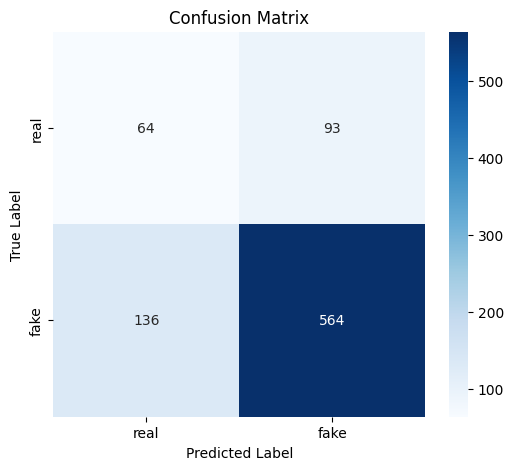

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
labels = ['real', 'fake']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Vẽ ROC Curve**
- ROC Curve cho thấy mô hình cân bằng giữa nhạy (recall) và độ chính xác giả (false positive).
AUC càng gần 1.0 thì mô hình càng tốt.

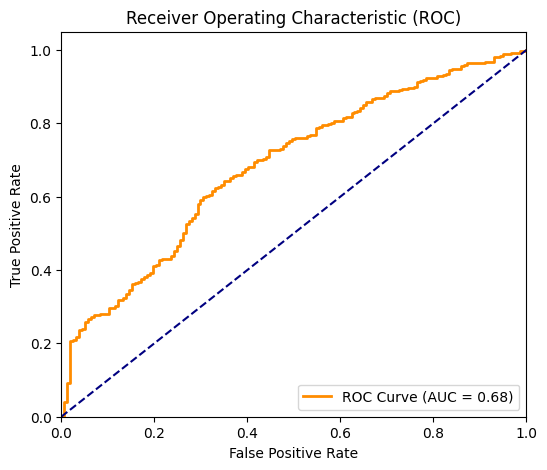

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
